## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [1]:
import os
import glob
from google.colab import drive

## load train, test and validation label arrays
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn.functional as F
import numpy as np

import torchvision.transforms as transforms
from PIL import Image

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="vqa_model.PNG">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [4]:
# load model
from load_model import load_model
vqa_resnet = load_model()

Downloading: "https://github.com/Cyanogenoid/pytorch-resnet/releases/download/hosting/resnet152-95e0e999.pth" to /root/.cache/torch/hub/checkpoints/resnet152-95e0e999.pth


In [ ]:
print(vqa_resnet) # for more information 

In [5]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [6]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Scale(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [7]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device) #返回的应该是encode加对应的单词长度。

In [8]:
# preprocess requires the dir_path of an image and the associated question. 
#It returns the specific input form which can be used directly by vqa model. 
def preprocess(dir_path, question):
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    image_size = 448  # scale image to given size and center
    central_fraction = 1.0
    transform = get_transform(image_size, central_fraction=central_fraction)
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    
    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0)) #img_features：转化好的图片的Tensor格式；q：token of word;q_len:length of word.
    return inputs

We provide you two pictures and some question-answers.

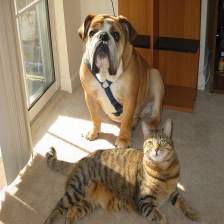

In [9]:
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
indices1 = [answer_to_index[ans] for ans in Answer1]# The indices of category ：类型的index
img1 = Image.open('dog_cat.png')
img1

In [10]:
dir_path = 'dog_cat.png' 
inputs = preprocess(dir_path, Question1)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy()) #return the idx of type making softmax the most
print(answer_words[answer_idx])

dog


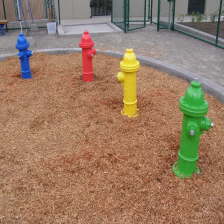

In [12]:
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_to_index[ans] for ans in Answer2]
img2 = Image.open('hydrant.png')
img2

In [13]:
dir_path = 'hydrant.png' 
inputs = preprocess(dir_path, Question2)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])
#print(ans)

green


### Grad-CAM 
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we foward propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (dog), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the two images. For each image, consider the answers we provided as the desired classes. Compare the heatmaps of different answers, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3` 
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

<img src="grad_cam.png">

In [14]:
import cv2

In [ ]:
# To do
print(vqa_resnet.resnet_layer4.r_model.layer4[2].conv3)

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


#########################IMPLEMENTATION STEP#######################

Rem:the order of backward_hook is also the order of forward;
here, we only need the gradient of feature maps(which is the output of conv2d),so we write grad_out;
what's more, grad_out is a list of list,we need [0] to get the value of gradient.

In [17]:
'''def comp_class_vec(ouput_vec, index=None):
    if not index:
        index = np.argmax(ouput_vec.cpu().data.numpy())
    else:
        index = np.array(index)
    index = index[np.newaxis, np.newaxis]
    index = torch.from_numpy(index)
    one_hot = torch.zeros(1, 3000).scatter_(1, index, 1)
    one_hot.requires_grad = True
    class_vec = torch.sum(one_hot * output)  

    return class_vec'''

In [18]:
def gen_cam(feature_map, grads):
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)  # cam shape (H, W)

    weights = np.mean(grads, axis=(1, 2))  

    for i, w in enumerate(weights):
        cam += w * feature_map[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)

    return cam

In [19]:
 '''heatmap with channel 1 transform to fade color image'''
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask),cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2_imshow(255*cam)
    cv2_imshow(255*img)
  

In [20]:
from google.colab.patches import cv2_imshow

In [32]:
#MAIN USED FUNCTION
def grad_cam(photo,question,answer):
  fmap_block = list()
  grad_block = list()

  def forward_hook(module, input, output):
    fmap_block.append(output)
  def backward_hook(module, grad_in, grad_out):
    grad_block.append(grad_out[0].detach())
  

  dir_path = photo 
  inputs = preprocess(dir_path, question)

  #register forward &backward hook
  vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_forward_hook(forward_hook)
  vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_backward_hook(backward_hook)
  #forward
  output = vqa_resnet(*inputs)

  # backward
  vqa_resnet.zero_grad()
    #define one_hot vector for backward propogation
  index = np.array(answer_to_index[answer])
  index = index[np.newaxis, np.newaxis]
  index = torch.from_numpy(index)
  one_hot = torch.zeros(1, 3000).scatter_(1, index, 1)
  one_hot.requires_grad = True
  class_vec = torch.sum(one_hot * output)
  class_vec.backward(retain_graph=True)

  grads_val = grad_block[0].cpu().data.numpy().squeeze()
  fmap = fmap_block[0].cpu().data.numpy().squeeze()

  #generate the image
  cam = gen_cam(fmap, grads_val)

  #show
  img = cv2.imread(photo)
  img_show = np.float32(cv2.resize(img, (224, 224))) / 255
  show_cam_on_image(img_show, cam)


###################For the first dog_cat image########################

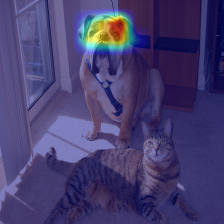

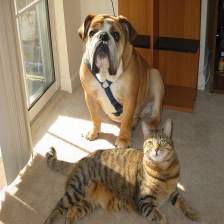

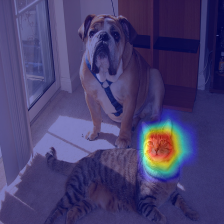

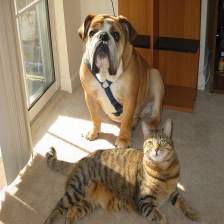

In [34]:
grad_cam('dog_cat.png',Question1,'dog')
grad_cam('dog_cat.png',Question1,'cat')

Conculsion for the first graph:

> We found that for dog, the grad_cam captures mainly the 'ear' and 'eye' features,while for cat, it captures the head of cat.In all, it captures the right features of our target.




#####################For the second hydrant image######################3



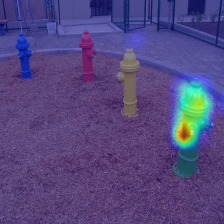

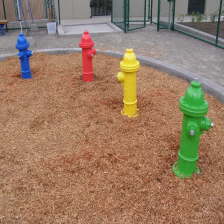

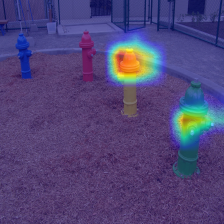

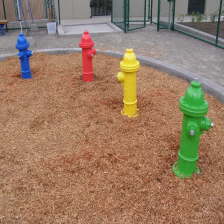

In [35]:
grad_cam('hydrant.png',Question2,'green')
grad_cam('hydrant.png',Question2,'yellow')

For the second 'hydrant' graph:


> We found that for 'green',the grad_cam captures mainly the middle part of green hydrant;while for 'yellow', it captures not only the head part of yellow hydrant,but also captures the middle part of green hydrant.Generally,  it gives us the right answer.





General Comment:

> The grad_cam studies the different features of different targets as we can see in the results above;But the drawback is that it can only show one target feature/time since its algorithm uses the average gradient(just as shown below,if we try to show 2 targets feautres at the same time,it gives us a little bit weird result.)



In [ ]:
def comp_class_vec_new(ouput_vec, index=None):
    if not index:
        index = np.argmax(ouput_vec.cpu().data.numpy())
    else:
        index = np.array(index)
   # index = index[np.newaxis]
    index = torch.from_numpy(index)
    one_hot = torch.zeros(2, 3000).scatter_(1, index, 1)
    one_hot.requires_grad = True
    class_vec = torch.sum(one_hot * output)  

    return class_vec

In [ ]:
answer_list=[[answer_to_index['dog']],[answer_to_index['cat']]]


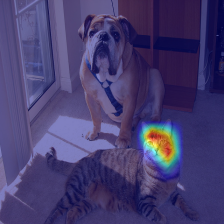

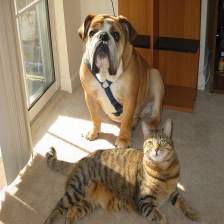

In [ ]:
fmap_block = list()
grad_block = list()

dir_path = 'dog_cat.png' 

inputs = preprocess(dir_path, Question1)


#net = vqa_resnet() # 
vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_forward_hook(forward_hook)
vqa_resnet.resnet_layer4.r_model.layer4[2].conv3.register_backward_hook(backward_hook)

output = vqa_resnet(*inputs)

# backward
vqa_resnet.zero_grad()
class_loss = comp_class_vec_new(output,answer_list)
class_loss.backward()

grads_val = grad_block[0].cpu().data.numpy().squeeze()
fmap = fmap_block[0].cpu().data.numpy().squeeze()
cam = gen_cam(fmap, grads_val)


img = cv2.imread("dog_cat.png")
img_show = np.float32(cv2.resize(img, (224, 224))) / 255
show_cam_on_image(img_show, cam)
